<h1> Sub-Movements and Hold Time <h1>

<h2> Overview:</h2>
1. Sub-movements <br>
2. Hold Time <br>
3. Fine-Tuning Parameters <br>
4. Computing Measures for Multiple Files

## Attribution

The custom functions for detecting gesture submovements and holds are sourced from the following EnvisionBox module: **Kinematic Feature Extraction for Motion Tracking Analysis**.

If you found this code helpful for your research, please cite the original source code material from the EnvisionBox website:

**Trujillo, J.P. & Pouw, W.T.J.L. (2021-11-18).** *Kinematic Feature Extraction for Motion Tracking Analysis.* Retrieved from: https://github.com/WimPouw/EnvisionBootcamp2021/tree/main/Python/Analysis_kinematic_features

**Trujillo, J.P., Vaitonyte, J., Simanova, I. et al. (2019).** Toward the markerless and automatic analysis of kinematic features: A toolkit for gesture and movement research. *Behavior Research Methods*, 51, 769–777. https://doi.org/10.3758/s13428-018-1086-8


In [1]:
import os
import numpy as np
import pandas as pd

import math
import numpy as np
import statistics

from scipy import signal
import matplotlib.pyplot as plt

import cv2
# Function to update the plot based on selected parameters
import ipywidgets as widgets
from IPython.display import display, clear_output, Video

In [2]:
df = pd.read_csv('timeseries/1295_LG_past_layout1_body.csv')

In [3]:
df.head()

,time,X_NOSE,Y_NOSE,Z_NOSE,visibility_NOSE,X_LEFT_EYE_INNER,Y_LEFT_EYE_INNER,Z_LEFT_EYE_INNER,visibility_LEFT_EYE_INNER,X_LEFT_EYE,...,Z_RIGHT_HEEL,visibility_RIGHT_HEEL,X_LEFT_FOOT_INDEX,Y_LEFT_FOOT_INDEX,Z_LEFT_FOOT_INDEX,visibility_LEFT_FOOT_INDEX,X_RIGHT_FOOT_INDEX,Y_RIGHT_FOOT_INDEX,Z_RIGHT_FOOT_INDEX,visibility_RIGHT_FOOT_INDEX
0,0.000000,0.565069,0.247220,-0.410739,0.999983,0.578396,0.224876,-0.389477,0.999967,0.583671,...,0.039227,0.834512,0.597988,1.061854,-0.016416,0.853982,0.514894,1.066935,-0.047116,0.898407
1,33.366667,0.569194,0.246173,-0.428578,0.999967,0.580743,0.223409,-0.408055,0.999924,0.585737,...,0.042831,0.768605,0.605471,1.067188,-0.015662,0.785137,0.513190,1.067497,-0.047198,0.827030
2,66.733333,0.565647,0.231879,-0.383986,0.999986,0.579452,0.213313,-0.359866,0.999974,0.585031,...,0.053272,0.828607,0.601774,1.066899,-0.025289,0.902844,0.511493,1.058726,-0.028773,0.911255
3,100.100000,0.565508,0.223886,-0.404098,0.999987,0.579531,0.205255,-0.378518,0.999975,0.584812,...,-0.006712,0.773319,0.608332,1.065782,-0.039087,0.766069,0.503691,1.106480,-0.111893,0.853309
4,133.466667,0.564351,0.242275,-0.397193,0.999990,0.578240,0.219495,-0.376005,0.999980,0.583760,...,0.013545,0.797292,0.603002,1.074032,-0.048669,0.831383,0.502232,1.097420,-0.078735,0.867890


In [4]:
def convert_MP_to_OP(df_MP):
    # first we create a dictionary that maps the names in our MediaPipe output to the names in our OpenPose output
    conv_dict = {"RIGHT_WRIST":"R_Hand", "LEFT_WRIST":"L_Hand","NOSE":"Nose","RIGHT_ELBOW":"RElb","LEFT_ELBOW":"LElb","RIGHT_HIP":"RHip","LEFT_HIP":"LHip", "LEFT_EYE":"LEye","RIGHT_EYE":"REye"}
    
    OP_df = pd.DataFrame()
    
    for key in conv_dict:
        
        OP_df[conv_dict[key]] = [[row["X_"+key],row["Y_"+key],row["Z_"+key]] for _,row in df_MP.iterrows()]
    OP_df["time"] = df_MP["time"].copy()
    
    # NOTE: not all methods track the exact same keypoints. For some of our calculations we need a Neck point, and a Mid-Hip Point.
    # We need to calculate these based on others
    OP_df["Neck"] = [[np.mean([row["X_LEFT_SHOULDER"],row["Y_RIGHT_SHOULDER"]]),np.mean([row["X_LEFT_SHOULDER"],row["Y_LEFT_SHOULDER"]]),row["Z_RIGHT_SHOULDER"] ] for _, row in df_MP.iterrows()]
    OP_df["MidHip"] = [[np.mean([row["X_LEFT_HIP"],row["X_RIGHT_HIP"]]),np.mean([row["Y_LEFT_HIP"],row["Y_LEFT_HIP"]]),row["Z_RIGHT_HIP"] ] for _, row in df_MP.iterrows()]
    return OP_df

MP_df_conv = convert_MP_to_OP(df)                                   
MP_df_conv.head()

,R_Hand,L_Hand,Nose,RElb,LElb,RHip,LHip,LEye,REye,time,Neck,MidHip
0,"[0.5194780826568604, 0.5722957253456116, -0.42...","[0.6198167204856873, 0.563133955001831, -0.409...","[0.5650694370269775, 0.2472196817398071, -0.41...","[0.4359984397888183, 0.5352767109870911, -0.25...","[0.6875771880149841, 0.5252792835235596, -0.22...","[0.5142331123352051, 0.6577374339103699, -0.00...","[0.6067705154418945, 0.6605061888694763, 0.003...","[0.5836707353591919, 0.2280900180339813, -0.38...","[0.5560632348060608, 0.2118735313415527, -0.39...",0.000000,"[0.4963909983634949, 0.4934351444244385, -0.17...","[0.5605018138885498, 0.6605061888694763, -0.00..."
1,"[0.5185180306434631, 0.5734796524047852, -0.41...","[0.6225519776344299, 0.5719520449638367, -0.38...","[0.5691940784454346, 0.246173158288002, -0.428...","[0.4383156597614288, 0.5280360579490662, -0.25...","[0.6860681176185608, 0.5234755277633667, -0.21...","[0.5135504603385925, 0.65312260389328, -0.0063...","[0.6072453260421753, 0.6566129922866821, 0.006...","[0.5857370495796204, 0.2268523871898651, -0.40...","[0.5578149557113647, 0.2098233103752136, -0.40...",33.366667,"[0.49599914252758026, 0.49525482952594757, -0....","[0.5603978931903839, 0.6566129922866821, -0.00..."
2,"[0.5183681845664978, 0.5725705027580261, -0.39...","[0.6199609637260437, 0.5625865459442139, -0.37...","[0.5656469464302063, 0.2318789064884185, -0.38...","[0.4365283548831939, 0.5331720113754272, -0.23...","[0.6888781189918518, 0.5243993997573853, -0.19...","[0.5122326016426086, 0.6564400792121887, -0.00...","[0.6051572561264038, 0.659491777420044, 0.0033...","[0.5850310921669006, 0.2183471024036407, -0.35...","[0.5564454793930054, 0.1995516419410705, -0.36...",66.733333,"[0.49636122584342957, 0.4948212802410126, -0.1...","[0.5586949288845062, 0.659491777420044, -0.003..."
3,"[0.5170607566833496, 0.5674775838851929, -0.43...","[0.6226442456245422, 0.5664777755737305, -0.39...","[0.5655084252357483, 0.2238858938217163, -0.40...","[0.4337875247001648, 0.5379900932312012, -0.25...","[0.6900806427001953, 0.5265364646911621, -0.21...","[0.5117480754852295, 0.6616522073745728, -0.00...","[0.6078492403030396, 0.6621724963188171, 0.004...","[0.5848122239112854, 0.2096675038337707, -0.37...","[0.5558241009712219, 0.1917837858200073, -0.37...",100.100000,"[0.4984055608510971, 0.4959664046764374, -0.17...","[0.5597986578941345, 0.6621724963188171, -0.00..."
4,"[0.520227313041687, 0.569710373878479, -0.4062...","[0.6233013868331909, 0.5671656727790833, -0.36...","[0.5643511414527893, 0.2422752976417541, -0.39...","[0.4371460080146789, 0.5378438234329224, -0.23...","[0.6893771886825562, 0.5227102637290955, -0.18...","[0.5148623585700989, 0.6597700119018555, -0.00...","[0.6086259484291077, 0.6605244874954224, 0.002...","[0.5837602615356445, 0.2226727604866027, -0.37...","[0.5546903014183044, 0.2074703574180603, -0.37...",133.466667,"[0.49719418585300446, 0.49418509006500244, -0....","[0.5617441534996033, 0.6605244874954224, -0.00..."


In [5]:
def calculate_distance(Hand, FPS):
    """
    Calculates the displacement and velocity between each set of points.

    Parameters:
    Hand (list of tuples): List of coordinate pairs representing hand positions over time.
    FPS (int): Frames per second.

    Returns:
    tuple: Two lists, one for displacement and one for velocity.
    """
    IDX = 0
    dist = []
    vel = []
    
    for coords in Hand[1:]:
        Prev_coords = Hand[IDX]
        # Calculate displacement using Euclidean distance
        DISPLACE = math.hypot(float(coords[0]) - float(Prev_coords[0]), float(coords[1]) - float(Prev_coords[1]))
        dist.append(DISPLACE)
        # Calculate velocity by multiplying displacement by FPS
        vel.append(DISPLACE * FPS)
        IDX += 1
    
    return (dist, vel)

<h2> Detecting Submovements </h2>

Submovements refer to the number of 'ballistic' movements being made during a gesture. The idea is to capture how many individual component movements make up a more complex one. To put this in perspective of the current example, there should be one movement (per hand) when the hands lift up and prepare to gesture, and then one inward movement and one outward movement for each "accordion playing" iteration. Number of submovements therefore gives us some indication of how complex a gesture is (i.e., how many different components does it have) or how repetitive it is (how frequently is the accordion action repeated).

Peak detection refers to finding local maxima and minima in signals and other data. In a visual sense, these are the "peaks" and "valleys" when we plot the data

One particularly useful function is scipy.signal.find_peaks. As the name suggests, it automatically finds potential peaks and valleys in a one-dimensional array of data samples.

The basic signature of find_peaks is:

find_peaks(signal, height=None, threshold=None, distance=None, 
           prominence=None, width=None, wlen=None, rel_height=0.5, 
           plateau_size=None)
The power of find_peaks comes from the ability to fine-tune the peak detection to suit your particular data. The function takes a signal array and identifies local maxima and minima based on the other parameters provided:

height – Required intensity or threshold for peaks <br>
threshold – Minimum intensity difference around peaks <br>
distance – Spacing between possible peaks <br>
prominence – Intensity difference from surrounding signal <br>
width – Width requirement for peaks <br>


Parameter	Description	Example
height	Minimum intensity value for peaks	height=2.0
threshold	Minimum difference from surrounding data	threshold=1.0
distance	Minimum spacing between peaks	distance=30
prominence	Intensity drop to either side of peaks	prominence=1.5
width	Required peak width	width=2
plateau_size	Number of samples for flat peak top	plateau_size=10

The function returns two arrays:

Indices of the identified peak locations
A dictionary containing properties like height and prominence for each peak

In [6]:

# Function to calculate submovements
def calc_submoves(df, FPS, hand, height=0, prominence=None, distance=None):
    results = {}
    hands = []
    if hand == 'L' or hand == 'B':
        hands.append("L_Hand")
    if hand == 'R' or hand == 'B':
        hands.append("R_Hand")

    for h in hands:
        _, hand_series = calculate_distance(df[h], FPS)
        
        if len(hand_series) >= 15:
            hand_smooth = signal.savgol_filter(hand_series, 15, 5)
        else:
            order = len(hand_series) - 1 if len(hand_series) % 2 == 0 else len(hand_series)
            hand_smooth = signal.savgol_filter(hand_series, order, 5)
        
        peaks, _ = signal.find_peaks(hand_smooth, height=height, prominence=prominence, distance=distance)
        results[h[0]] = (hand_smooth, peaks)
    
    return results

# Function to find movement pauses
def find_movepauses(velocity_array):
    # finds moments when velocity is below a particular threshold
    # We are using a 0.5px/s threshold, but this can be adjusted
    # returns array of indices for those moments
    threshold = 0.5
    velocity_array = np.array(velocity_array)
    return np.where(velocity_array < threshold)[0]

# Function to calculate holds
def calc_holds(df, subslocs_L, subslocs_R, FPS, hand):
    # calculates the number of holds, time spent in a hold, and the average duration of any holds

    def get_hold_indices(df, column_name):
        _, velocity_series = calculate_distance(df[column_name], FPS)
        return find_movepauses(velocity_series)

    right_side_columns = ["RElb", "R_Hand", "R_finger"]
    left_side_columns = ["LElb", "L_Hand", "L_finger"]

    if hand in ['R', 'B']:
        right_holds = [get_hold_indices(df, col) for col in right_side_columns if col in df.columns]
        if len(right_holds) > 1:
            GR = np.intersect1d(np.intersect1d(right_holds[0], right_holds[1]), right_holds[2] if len(right_holds) > 2 else right_holds[1])
        else:
            GR = right_holds[0]
    else:
        GR = []

    if hand in ['L', 'B']:
        left_holds = [get_hold_indices(df, col) for col in left_side_columns if col in df.columns]
        if len(left_holds) > 1:
            GL = np.intersect1d(np.intersect1d(left_holds[0], left_holds[1]), left_holds[2] if len(left_holds) > 2 else left_holds[1])
        else:
            GL = left_holds[0]
    else:
        GL = []

    if hand == 'B':
        full_hold = np.intersect1d(GL, GR)
    elif hand == 'L':
        full_hold = GL
    elif hand == 'R':
        full_hold = GR

    if len(full_hold) == 0:
        return 0, 0, 0, [], 0

    hold_cluster = np.split(full_hold, np.where(np.diff(full_hold) > 5 )[0] + 1)
    initial_move = min(np.concatenate((subslocs_L, subslocs_R), axis=None)) if hand == 'B' else (min(subslocs_L) if hand == 'L' else min(subslocs_R))

    hold_cluster = [cluster for cluster in hold_cluster if cluster[0] >= initial_move]


    hold_count = len([cluster for cluster in hold_cluster if len(cluster) >= 3])
    hold_time = sum([len(cluster) for cluster in hold_cluster if len(cluster) >= 3]) / FPS
    hold_avg = statistics.mean([len(cluster) for cluster in hold_cluster if len(cluster) >= 3]) / FPS if hold_count > 0 else 0

    return hold_count, hold_time, hold_avg, full_hold, initial_move, hold_cluster

# Function to update the plot based on the current frame
def update_plot(frame_idx, height=0, prominence=None, distance=None):
    global results
    results = calc_submoves(MP_df_conv, 29.97, 'B', height=height, prominence=prominence, distance=distance)
    
    with plot_output:
        plot_output.clear_output(wait=True)
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        for ax, (hand, (smooth, peaks)) in zip(axes, results.items()):
            ax.plot(smooth)
            ax.plot(peaks, smooth[peaks], "x")
            ax.set_xlabel("Frame")
            ax.set_ylabel("Velocity")
            ax.plot(np.full(len(smooth), 0.1), "--", color="gray")
            ax.axvline(x=frame_idx, color='r', linestyle='--')
            if hand == 'L':
                ax.set_title("Left Hand Movements at Frame {}".format(frame_idx))
            elif hand == 'R':
                ax.set_title("Right Hand Movements at Frame {}".format(frame_idx))
        plt.tight_layout()
        plt.show()

# Function to update video frame and plot
def update_video_and_plot(frame_idx, height, prominence, distance):
    frame = get_frame(frame_idx)
    if frame is not None:
        with video_output:
            video_output.clear_output(wait=True)
            plt.imshow(frame)
            plt.axis('off')
            plt.show()
    
    update_plot(frame_idx, height, prominence, distance)

# Video file path (replace with actual path)
video_file = "P:/shared/FOCUS-GROUPS/Gesture-Kinematics/for_Mounika/1295_LG_past_layout1.mp4"

# Read video
cap = cv2.VideoCapture(video_file)
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Function to get a frame from the video
def get_frame(frame_idx):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    if not ret:
        return None
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Function to handle hold computation and plotting
def compute_holds(b):
    global holds_info, results
    results = calc_submoves(MP_df_conv, 29.97, 'B', height_slider.value, prominence_slider.value, distance_slider.value)
    L_peaks = results['L'][1]
    R_peaks = results['R'][1]
    holds_info = calc_holds(MP_df_conv, L_peaks, R_peaks, 29.97, "B")
    hold_count, hold_time, hold_avg, full_hold, initial_move, hold_cluster = holds_info
    print("Number of holds:", hold_count)
    print("Total hold time:", hold_time, "seconds")
    print("Average hold duration:", hold_avg, "seconds")
    
    with plot_output:
        plot_output.clear_output(wait=True)
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        for ax, (hand, (smooth, peaks)) in zip(axes, results.items()):
            ax.plot(smooth, label='Velocity')
            ax.plot(peaks, smooth[peaks], "x", label='Peaks')
            ax.set_xlabel("Frame")
            ax.set_ylabel("Velocity")
            ax.plot(np.full(len(smooth), 0.25), "--", color="gray", label='Threshold')

            # Plotting the start and end points of each hold
            # Plotting the start and end points of each hold
            for i, cluster in enumerate(hold_cluster):
                if len(cluster) >= 3:
                    start_label = f'H{i+1}-S'
                    end_label = f'H{i+1}-E'
                    ax.axvline(x=cluster[0], color='blue', linestyle='-', label='_nolegend_')
                    ax.axvline(x=cluster[-1], color='red', linestyle='-', label='_nolegend_')
                    ax.text(cluster[0], ax.get_ylim()[1], start_label, rotation=0, verticalalignment='bottom', color='blue', fontsize=10)
                    ax.text(cluster[-1], ax.get_ylim()[1], end_label, rotation=0, verticalalignment='bottom', color='red', fontsize=10)

        
            # Adding titles
            if hand == 'L':
                ax.set_title("Left Hand Movements at Frame {}".format(frame_slider.value), fontsize=15, pad=20)
            elif hand == 'R':
                ax.set_title("Right Hand Movements at Frame {}".format(frame_slider.value), fontsize=15, pad=20)
        
        # Remove duplicate labels in the legend
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), loc='upper right')

        plt.tight_layout()
        plt.show()



# Create widgets
height_slider = widgets.FloatSlider(value=0, min=0, max=1, step=0.1, description='Height:')
prominence_slider = widgets.FloatSlider(value=0, min=0, max=1, step=0.1, description='Prominence:')
distance_slider = widgets.IntSlider(value=1, min=1, max=10, step=1, description='Distance:')
frame_slider = widgets.IntSlider(value=0, min=0, max=num_frames-1, step=1, description='Frame:')
play_button = widgets.Play(value=0, min=0, max=num_frames-1, step=1, interval=50, description="Press play", disabled=False)
compute_button = widgets.Button(description="Compute Holds")

# Link the sliders and play button to the update function
widgets.jslink((play_button, 'value'), (frame_slider, 'value'))

# Function to update both video and plot when sliders change
def on_slider_change(change):
    update_video_and_plot(frame_slider.value, height_slider.value, prominence_slider.value, distance_slider.value)

frame_slider.observe(on_slider_change, names='value')
height_slider.observe(on_slider_change, names='value')
prominence_slider.observe(on_slider_change, names='value')
distance_slider.observe(on_slider_change, names='value')
compute_button.on_click(compute_holds)

# Video and plot output widgets
video_output = widgets.Output()
plot_output = widgets.Output()

# Display widgets
ui = widgets.HBox([
    widgets.VBox([height_slider, prominence_slider, distance_slider, frame_slider, play_button, compute_button], layout=widgets.Layout(margin='0 50px 0 0')),
    widgets.VBox([video_output, plot_output])
])
display(ui)

# Initial plot and video display
update_video_and_plot(0, 0, None, None)

<h2> Calculating Number of Holds, Time Spent in a Hold, and the Average Duration of Holds. </h2>

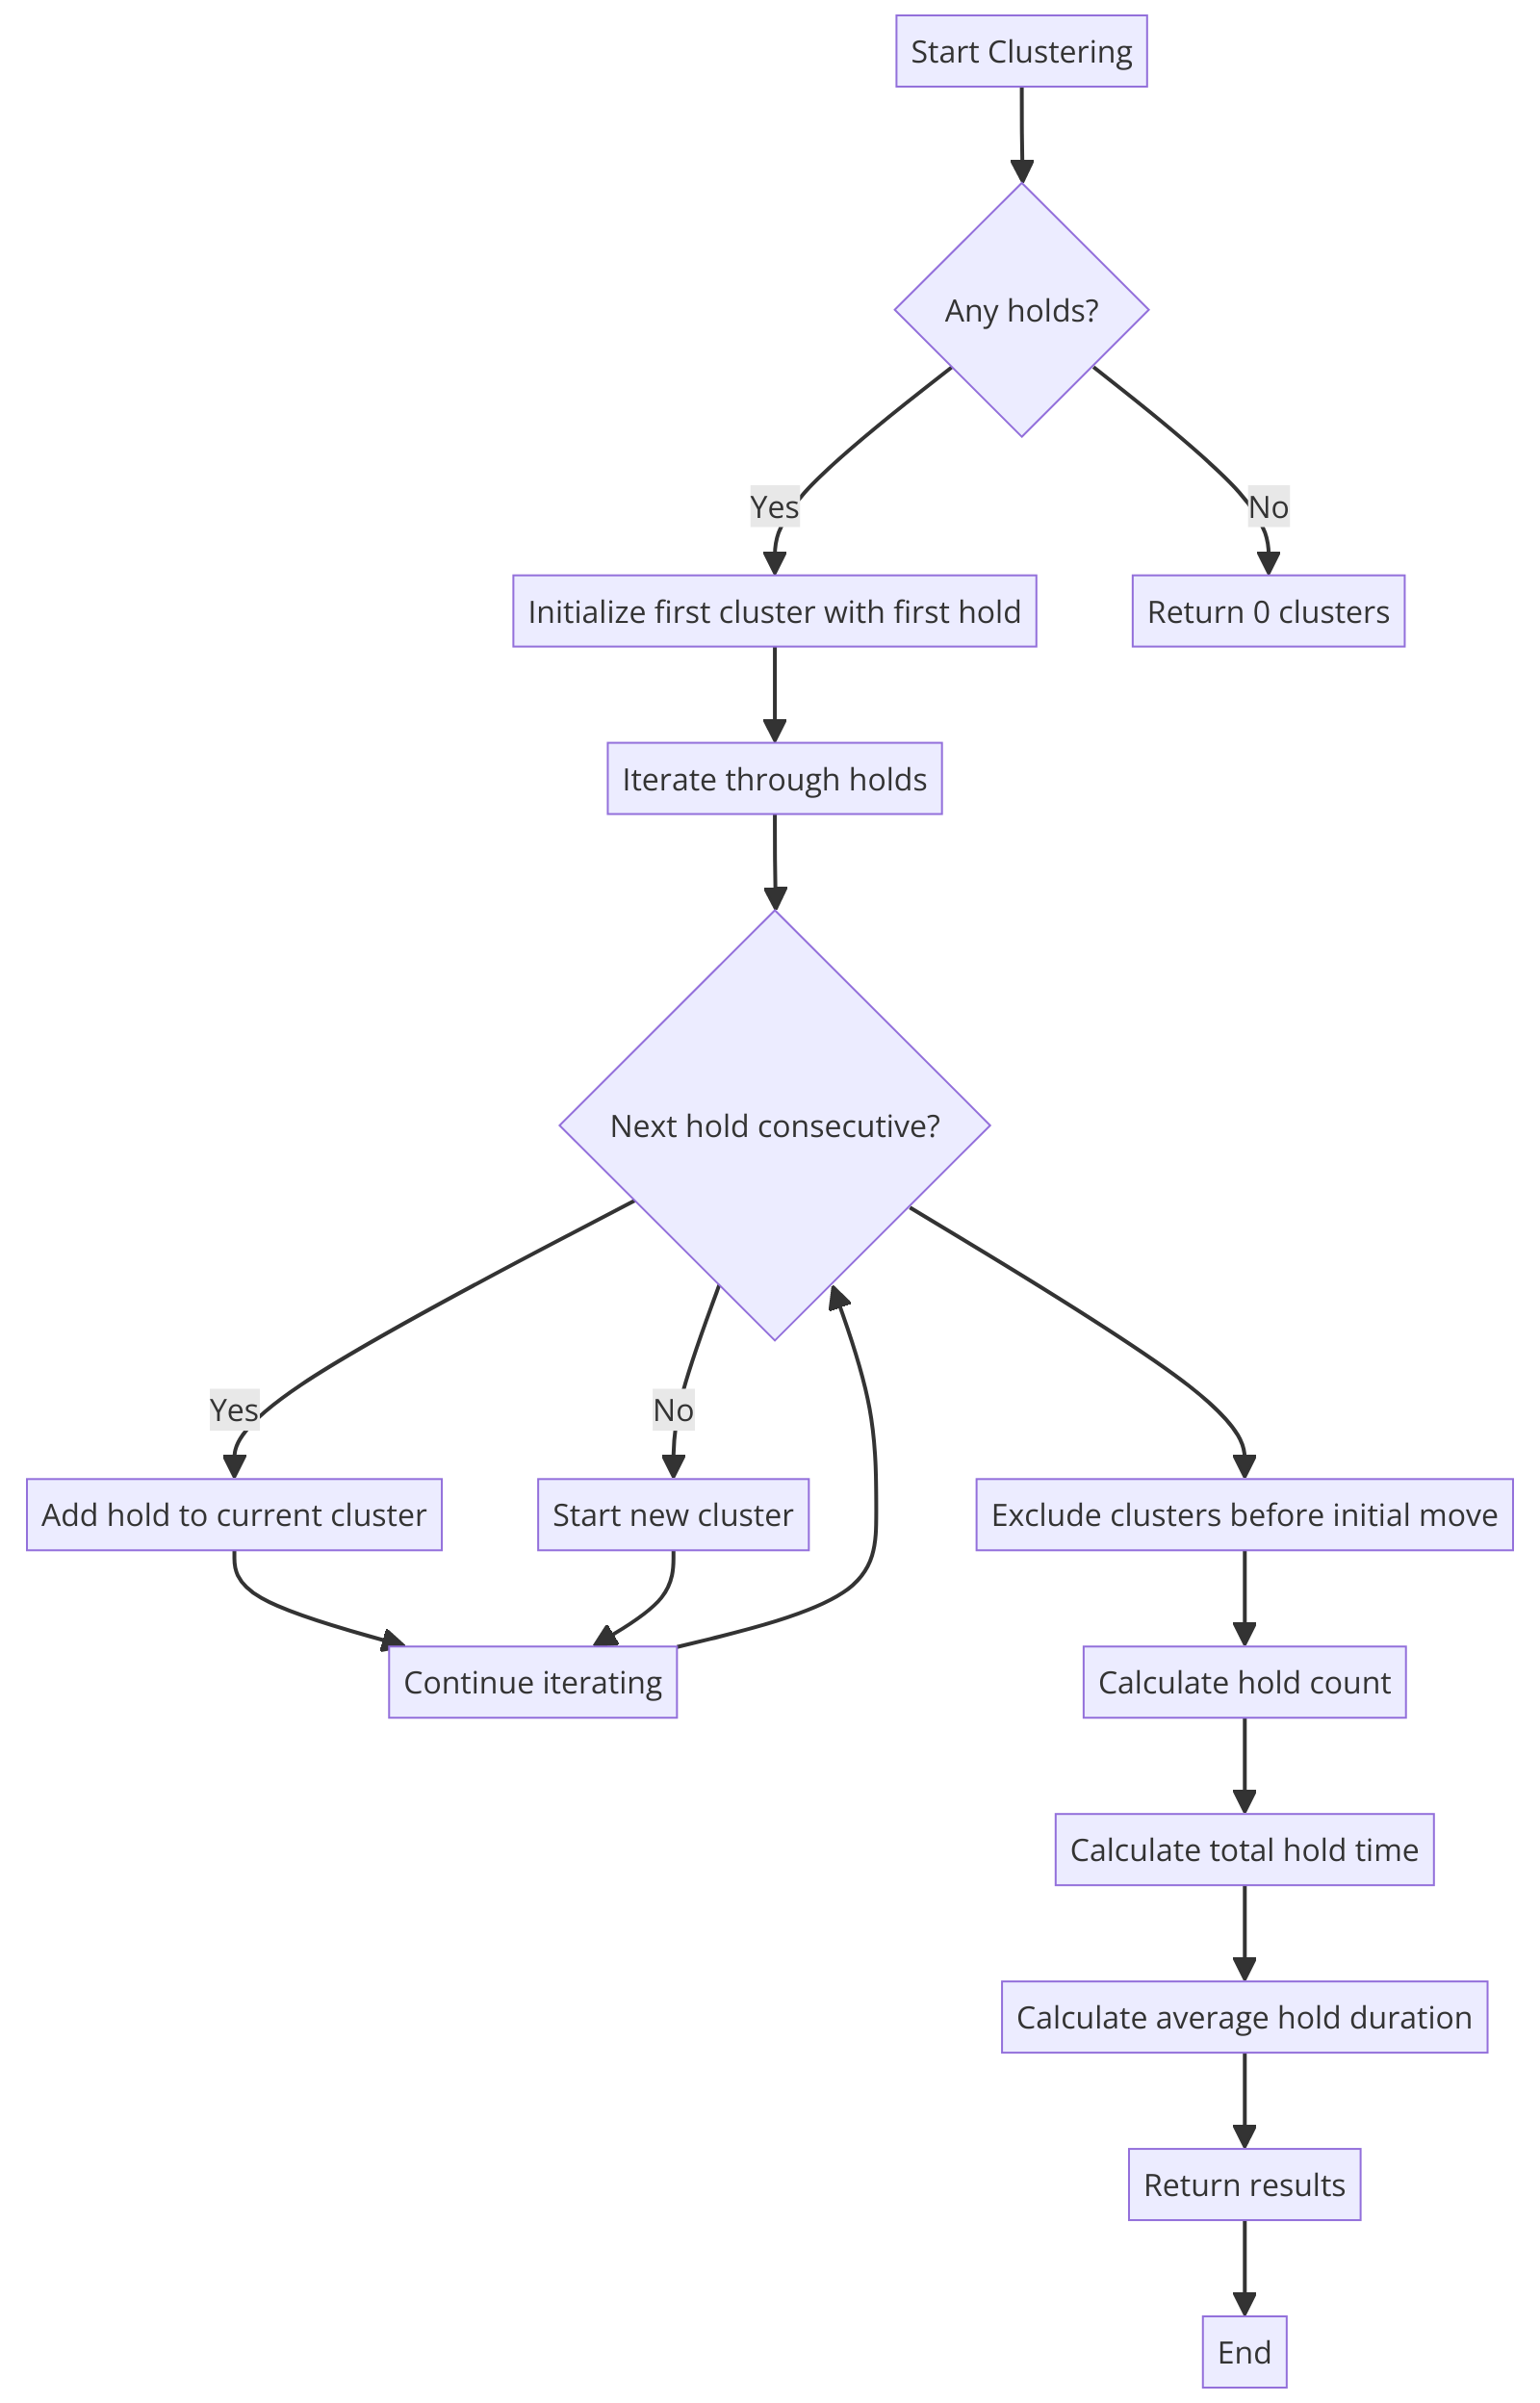

In [7]:
from IPython.display import display, Image

# Adjust the width as needed (e.g., 50%)
display(Image(filename="diagram.png", width=400))

In [8]:
from ipywidgets import Widget
Widget.close_all()

<h2> Creating a Final Results File </h2>

In [12]:
path = 'P:/shared/FOCUS-GROUPS/Gesture-Kinematics/submoves_hold/timeseries/'

MT_files = [file for file in os.listdir(path) if file.endswith(".csv")] #Reading list of motion tracking files from the folder
 #Reading list of ELAN files from the folder

results_df = pd.DataFrame(columns = ["file", "num_holds", "avg_hold_duration"]) #Creating an empty dataframe to store the results

for MT_file in MT_files:
    df = pd.read_csv(path + MT_file) #Reading the motion tracking file
    MP_df_conv = convert_MP_to_OP(df) #Converting the motion tracking file to OpenPose format
    results = calc_submoves(MP_df_conv, 29.97, 'B', height_slider.value, prominence_slider.value, distance_slider.value)
    L_peaks = results['L'][1]
    R_peaks = results['R'][1]
    holds_info = calc_holds(MP_df_conv, L_peaks, R_peaks, 29.97, "B")
    hold_count, hold_time, hold_avg, full_hold, initial_move, hold_cluster = holds_info


    results_df = pd.concat([results_df, pd.DataFrame([{"file": MT_file, "num_holds": hold_count, "avg_hold_duration": hold_avg}])]) #Storing the results in the dataframe


C:\Users\moukan\AppData\Local\Temp\ipykernel_27560\679083581.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([{"file": MT_file, "num_holds": hold_count, "avg_hold_duration": hold_avg}])]) #Storing the results in the dataframe


In [13]:
results_df.head() #Displaying the results

,file,num_holds,avg_hold_duration
0,1295_LG_past_layout1_body.csv,16,6.335502
0,4020_NH_present_layout1_body.csv,0,0.000000


In [14]:
results_df.to_csv("results.csv", index=False) #Saving the results to a CSV file